# Final Project: Building a daily life assistant with an Instruction-Fine-Tuned GPT-2

> Adrien Lindeberg - Grégoire Ugollini - ESIEE 2024-2025

---


Dans ce projet, on eux fine-tuné le modèle GPT-2 préentraîné pour qu'il puisse répondre efficacement à des questions sur diverses maladies, leurs symptômes et leurs traitements. Grâce à un dataset contenant des informations médicales précises (comme sur le glaucoma), l'objectif est de spécialisé notre modèle dans le domaine de la santé.

Tout d'abord nous vérifions les versions de nos librairies pour voir si elles sont à jour.

In [4]:
from importlib.metadata import version

pkgs = [
    "matplotlib",
    "pandas",
    "tiktoken",
    "torch",
    "tqdm",
    "tensorflow",
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.8.3
pandas version: 2.2.1
tiktoken version: 0.6.0
torch version: 2.2.2
tqdm version: 4.67.1
tensorflow version: 2.16.1


## Transformation des données

Avant de passer au fine-tuning nous devons mettre en forme nos données pour qu'elles soit simple à comprendre pour notre modèle.

Nous allons utiliser le alcapa-style format sur nos données qui est un format reconnu nous assurant une certainn efficacité.

Nous avons récupérer notre dataset sur le github public de nishantkushwaha-1999: https://github.com/nishantkushwaha-1999/llm_fine_tuning_optimization

In [5]:
import pandas as pd

dataset = pd.read_csv("dataset.csv")


In [6]:
dataset.head()

,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


Dans notre dataset les deux colonnes qui nous intéressent principalement sont question et answer.

In [7]:
len(dataset)

4000

Notre dataset compte 4000 échantillons ce qui représentr une bonne fourchette de données.

In [5]:
import pandas as pd
import json

def convert_to_alpaca_style(data: pd.DataFrame, output_file='json_instructions.json'):

    if 'question' not in data.columns or 'answer' not in data.columns:
        raise ValueError("Le DataFrame doit contenir les colonnes 'question' et 'answer'.")

    filtered_data = data.dropna(subset=['question', 'answer'])

    json_instruct = [
        {
            "instruction": "Provides a precise answer to the following question.",
            "input": row['question'],
            "output": row['answer']
        }
        for _, row in filtered_data.iterrows()
    ]

    with open(output_file, 'w') as f:
        json.dump(json_instruct, f, indent=4)

    return json_instruct


In [6]:
json_instructions = convert_to_alpaca_style(dataset)

Nous convertissons ici nos données et supprimons les échantillons qui ont une valeur manquante dans une des deux colonnes question et answe et les conservont dans un fichier json.

In [7]:
len(json_instructions)

3998

In [8]:
json_instructions[:5]

[{'instruction': 'Provides a precise answer to the following question.',
  'input': 'What is (are) Glaucoma ?',
  'output': "Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. While glaucoma can strike anyone, the risk is much greater for people over 60. How Glaucoma Develops  There are several different types of glaucoma. Most of these involve the drainage system within the eye. At the front of the eye there is a small space called the anterior chamber. A clear fluid flows through this chamber and bathes and nourishes the nearby tissues. (Watch the video to learn more about glaucoma. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.) In glaucoma, for still unknown reasons, the fluid drains too slowly out of the eye. As the fluid builds up, the pressure inside the eye rises. Unless this pressure is controlled, it may cause damage to the

On peut voir nos données au format désiré.

## Formattage des données


Maintenant que nous avons transformer nos données nous pouvons les convertire au format alpaca-style.

Donc nous récupérons nos données transformées dans le fichier json.

In [9]:
import json
import os
import urllib


def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    data = json.loads(text_data)
    return data


file_path = "json_instructions.json"
url = ""

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 3998


In [10]:
data = data[:1100]
len(data)

1100

Nous avons décidé de réduire à 1100 échantillons notre dataset pour réduire le  temps d'entrainement. Au complet, le temps d'entrainement duré plus d'une journée et on ne pouvait pas utilisé la version gratuite du GPU de google collab car le fine-tuning demandé trop de calculs.

In [11]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Provides a precise answer to the following question.', 'input': 'How to prevent Urinary Tract Infections ?', 'output': 'Changing some of these daily habits may help prevent UTIs. - Wipe from front to back after using the toilet. Women should wipe from front to back to keep bacteria from getting into the urethra. This step is most important after a bowel movement.  Wipe from front to back after using the toilet. Women should wipe from front to back to keep bacteria from getting into the urethra. This step is most important after a bowel movement.  - Drink lots of fluid, especially water. Fluids can help flush bacteria from the urinary system. Water is best. Most healthy people should try to drink six to eight, 8-ounce glasses of fluid each day. (Some people need to drink less water because of certain conditions. For example, if you have kidney failure or heart disease, you should not drink this much fluid. Ask your health care provider how much fluid is 

In [12]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': 'Provides a precise answer to the following question.', 'input': 'what research (or clinical trials) is being done for Childhood Acute Myeloid Leukemia and Other Myeloid Malignancies ?', 'output': "New types of treatment are being tested in clinical trials.\n                    This summary section describes treatments that are being studied in clinical trials. It may not mention every new treatment being studied. Information about clinical trials is available from the NCI website.     Biologic therapy     Biologic therapy is a treatment that uses the patients immune system to fight cancer. Substances made by the body or made in a laboratory are used to boost, direct, or restore the bodys natural defenses against cancer. This type of cancer treatment is also called biotherapy or immunotherapy.     Natural killer (NK) cells are a type of biologic therapy. NK cells are white blood cells that can kill tumor cells. These may be taken from a donor and

Sur la figure ci-dessus à gauche, nous pouvons voir a quoi correspond le format alpaca-style:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/prompt-style.webp" width=500px>

Ci-dessous, nous utilisons la fonction format_input pour convertir chaque donnée au format voulue:

In [13]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

Nous pouvons voir ici une réponse formatté.

In [14]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Provides a precise answer to the following question.

### Input:
How to prevent Urinary Tract Infections ?

### Response:
Changing some of these daily habits may help prevent UTIs. - Wipe from front to back after using the toilet. Women should wipe from front to back to keep bacteria from getting into the urethra. This step is most important after a bowel movement.  Wipe from front to back after using the toilet. Women should wipe from front to back to keep bacteria from getting into the urethra. This step is most important after a bowel movement.  - Drink lots of fluid, especially water. Fluids can help flush bacteria from the urinary system. Water is best. Most healthy people should try to drink six to eight, 8-ounce glasses of fluid each day. (Some people need to drink less water because of certain conditions. For example, if you have kidney failure or heart di

Maintenant que nos données sont formattés, nous allons les divisé en trois data loaders: un d'entrainement, de validation et de test

Nous avons décidé d'avoir 15% des données dans notre ensemble de validation et 10% dans notre ensemble de test. Notre ensemble d'entrainement contient toutes les données car ici nous l'netrainons sur des données précises qu'il ne peut inventer si il ne les as jamais vu et ne peut pas les deviner en fonction des autres données.

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_dataset(data, val_fraction=0.15, test_fraction=0.10):
    
    val_test_fraction = val_fraction + test_fraction
    train_data, val_test_data = train_test_split(
        data, test_size=val_test_fraction, random_state=42
    )
    
    val_data, test_data = train_test_split(
        val_test_data, 
        test_size=test_fraction / val_test_fraction,  # Proportion relative à val_test_data
        random_state=42
    )

    return data, val_data, test_data


In [16]:
train_data, val_data, test_data = split_dataset(data)

print("Train Data (100 % des données) :")
print(len(train_data))

print("\nValidation Data (15 % des données) :")
print(len(val_data))

print("\nTest Data (10 % des données) :")
print(len(test_data))


Train Data (100 % des données) :
1100

Validation Data (15 % des données) :
165

Test Data (10 % des données) :
110


Nous nous retrouvons avec une dataset d'entrainement de 1100 données, un dataset de validation avec 165 données et un dataset de test avec 110 données.

Nous visualizons ici nos données

In [17]:
train_data[0]

{'instruction': 'Provides a precise answer to the following question.',
 'input': 'What is (are) Glaucoma ?',
 'output': "Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. While glaucoma can strike anyone, the risk is much greater for people over 60. How Glaucoma Develops  There are several different types of glaucoma. Most of these involve the drainage system within the eye. At the front of the eye there is a small space called the anterior chamber. A clear fluid flows through this chamber and bathes and nourishes the nearby tissues. (Watch the video to learn more about glaucoma. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.) In glaucoma, for still unknown reasons, the fluid drains too slowly out of the eye. As the fluid builds up, the pressure inside the eye rises. Unless this pressure is controlled, it may cause damage to the op

In [18]:
val_data[0]

{'instruction': 'Provides a precise answer to the following question.',
 'input': 'What are the treatments for Osteoarthritis ?',
 'output': 'Treatment Goals: Manage Pain, Improve Function Osteoarthritis treatment plans often include ways to manage pain and improve function. Such plans can include exercise, rest and joint care, pain relief, weight control, medicines, surgery, and non-traditional treatment approaches. Current treatments for osteoarthritis can relieve symptoms such as pain and disability, but right now there are no treatments that can cure osteoarthritis. Exercise: One of the Best Treatments Exercise is one of the best treatments for osteoarthritis. It can improve mood and outlook, decrease pain, increase flexibility, and help you maintain a healthy weight. The amount and form of exercise will depend on which joints are involved, how stable the joints are, whether or not the joint is swollen, and whether a joint replacement has already been done. Ask your doctor or physi

Nous implémentons une classe InstructionDataset qui pré-tokenizes nos données aux bon format.

In [19]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

Nos données n'ont pas toutes la même longueur or nous voulons mettre plusieurs échantillons dans des batchs pour accélerer l'entrainement. Nous allons donc ajouter un padding ici `<|endoftext|>` token pour que chaque échantillon ait la même longueur.

In [20]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]



Nous développons une fonction « collate » personnalisée que nous pouvons passer au data loader.
Cette fonction permet d'aligner les exemples d'entraînement de chaque lot sur la même longueur (mais les différents lots peuvent avoir des longueurs différentes).

De plus, pour l'entraînement LLM, nous avons également besoin des valeurs cibles donc les cibles sont les entrées décalées d'une position vers la droite, afin que le LLM apprenne à prédire le prochain jeton.

Nous mettons aussi en place une valeur `ignore_index` pour remplacer tous les ID de jetons de remplissage par une nouvelle valeur. Ici, nous remplaçons les tokens ID correspondant à `50256` par `-100`.

Pour finir, on ajoute le paramètre `allowed_max_length` au cas où nous voudrions limiter la longueur des échantillons.

In [33]:
def custom_collate(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

Nous voulons déplacer maintenant directement les données vers le dispositif cible (pour nous un cpu) au lieu de le faire dans la boucle d'entraînement principale, ce qui améliore l'efficacité parce que cela peut être effectué comme un processus de fond lorsque nous utilisons la fonction `custom_collate_fn` comme une partie du chargeur de données.
La fonction `partial` de la bibliothèque `functools`, nous permet de créer une nouvelle fonction avec l'argument `device` de la fonction originale pré-rempli.

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)

Device: cpu


In [36]:
from functools import partial

customized_collate_fn = partial(custom_collate, device=device, allowed_max_length=1024)

Nous instantions enfin nos data loaders.

In [37]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [38]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [39]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 825]) torch.Size([8, 825])
torch.Size([8, 1024]) torch.Size([8, 1024])


torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 673]) torch.Size([8, 673])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 765]) torch.Size([8, 765])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 688]) torch.Size([8, 688])
torch.Size([8, 629]) torch.Size([8, 629])
torch.Size([8, 986]) torch.Size([8, 986])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 445]) torch.Size([8, 445])
torch.Size([8, 972]) torch.Size([8, 972])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 426]) torch.Size([8, 426])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 330]) torch.Size([8, 330])
torch.

Come on peut le voir, chaque batch a une longueur différente comme désiré.

In [40]:
print(inputs[0])

tensor([21106,   318,   281,  ..., 50256, 50256, 50256])


In [41]:
print(targets[0])

tensor([  318,   281, 12064,  ...,  -100,  -100,  -100])


Maintenant que nos données sont prêtes, on télécharge le modèle pré-entrainé GPT2 avec 355 million de parametres.

In [29]:
from gpt_download import download_and_load_gpt2
from gpt import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


In [30]:
import torch

torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Provides a precise answer to the following question.

### Input:
What are the treatments for Osteoarthritis ?


In [31]:
val_data[0]

{'instruction': 'Provides a precise answer to the following question.',
 'input': 'What are the treatments for Osteoarthritis ?',
 'output': 'Treatment Goals: Manage Pain, Improve Function Osteoarthritis treatment plans often include ways to manage pain and improve function. Such plans can include exercise, rest and joint care, pain relief, weight control, medicines, surgery, and non-traditional treatment approaches. Current treatments for osteoarthritis can relieve symptoms such as pain and disability, but right now there are no treatments that can cure osteoarthritis. Exercise: One of the Best Treatments Exercise is one of the best treatments for osteoarthritis. It can improve mood and outlook, decrease pain, increase flexibility, and help you maintain a healthy weight. The amount and form of exercise will depend on which joints are involved, how stable the joints are, whether or not the joint is swollen, and whether a joint replacement has already been done. Ask your doctor or physi

In [32]:
from gpt import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [33]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Output:

The answer is:

### Instruction:

Provides a precise answer to the following question.

### Input:


On test le modèle avant le fine-tuning et on voit qu'il est vraimentmauvais à l'heure actuelle.

In [34]:
from gpt import (
    calc_loss_loader,
    train_model_simple
)

Nous calculons la perte initiale des ensembles d'entraînement et de validation avant de commencer l'entraînement.

In [35]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 2.2456435203552245
Validation loss: 2.3255316257476806


Nous lançons ici le fine-tuning sur 2 epochs.

In [36]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.132, Val loss 2.076
Ep 1 (Step 000005): Train loss 1.780, Val loss 1.667
Ep 1 (Step 000010): Train loss 1.555, Val loss 1.496
Ep 1 (Step 000015): Train loss 1.384, Val loss 1.422
Ep 1 (Step 000020): Train loss 1.445, Val loss 1.373
Ep 1 (Step 000025): Train loss 1.354, Val loss 1.344
Ep 1 (Step 000030): Train loss 1.357, Val loss 1.314
Ep 1 (Step 000035): Train loss 1.356, Val loss 1.293
Ep 1 (Step 000040): Train loss 1.285, Val loss 1.271
Ep 1 (Step 000045): Train loss 1.378, Val loss 1.253
Ep 1 (Step 000050): Train loss 1.209, Val loss 1.232
Ep 1 (Step 000055): Train loss 1.191, Val loss 1.225
Ep 1 (Step 000060): Train loss 1.137, Val loss 1.202
Ep 1 (Step 000065): Train loss 1.116, Val loss 1.192
Ep 1 (Step 000070): Train loss 1.104, Val loss 1.166
Ep 1 (Step 000075): Train loss 1.183, Val loss 1.154
Ep 1 (Step 000080): Train loss 1.092, Val loss 1.144
Ep 1 (Step 000085): Train loss 1.099, Val loss 1.128
Ep 1 (Step 000090): Train loss 1.062, Val loss

Comme nous pouvons le voir sur la base des résultats ci-dessus, le modèle s'entraîne bien, comme nous pouvons le constater sur la base des valeurs décroissantes de la perte d'entraînement et de la perte de validation
De plus, en se basant sur le texte de réponse imprimé après chaque époque, nous pouvons voir que le modèle suit correctement l'instruction de convertir la phrase d'entrée « Le chef cuisine le repas tous les jours » en voix passive « Le repas est cuisiné tous les jours par le chef » (nous formaterons et évaluerons correctement les réponses dans une section ultérieure).

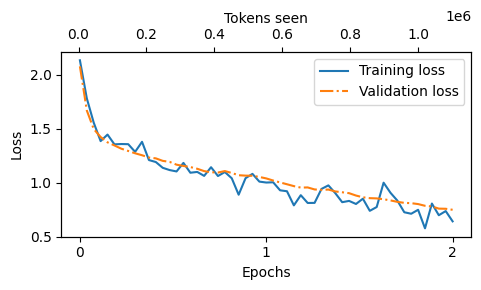

In [37]:
from gpt import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

Comme on peut le voir, la perte diminue fortement au début de la première époque, ce qui signifie que le modèle commence à apprendre rapidement
La courbe de la perte de validation suit parfaitement la courbe de la perte d'entrainement ce qui est encourageant.

Nous testons notre modèle et comparons la réponse générée à la réponse attendue.

In [38]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Provides a precise answer to the following question.

### Input:
What are the symptoms of Laryngeal Cancer ?

Correct response:
>> Signs and symptoms of laryngeal cancer include a sore throat and ear pain. These and other signs and symptoms may be caused by laryngeal cancer or by other conditions. Check with your doctor if you have any of the following:         - A sore throat or cough that does not go away.    - Trouble or pain when swallowing.    - Ear pain.    - A lump in the neck or throat.    - A change or hoarseness in the voice.

Model response:
>> Signs and symptoms of laryngeal cancer include a sore throat, ear pain, and difficulty swallowing. These and other signs and symptoms may be caused by laryngeal cancer or by other conditions. Check with your doctor if you have any of the following:         - A sore throat.    - Ear pain.    - Trouble swallowing. 

Le modèle semble performer bien la réponse génére se rapproche fortement de la réponse attendue.

Maintenant, nous allons générer une réponse pour chaque échantillons de notre dataset de test pour les comparer avec les réponses attendues. Nous créons un fichier json instruction-data-with-response.json qui va stocker la réponse générée et la réponse attendue.

In [ ]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

 45%|████▍     | 49/110 [52:19<1:28:32, 87.10s/it]

In [ ]:
print(test_data[0])

Nous enregistrons notre modèle pour ne pas avoir à relancer le fine-tuning à chaque fois.

In [ ]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Pour évaluer nos réponsesn nous allons utiliser le modèle llama3 grâce à ollama.

In [1]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


On vérifie que ollama est bien en train de tourné.

In [4]:
# This cell is optional; it allows you to restart the notebook
# and only run section 7.7 without rerunning any of the previous code
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

La fonction suivante permet d'envoyer un prompt au modèle désiré avec ollama.

In [5]:
import urllib.request

def query_model(prompt, model="llama3", url="http://localhost:11434/api/chat"):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


model = "llama3"

On va générer un score pour chaque réponse et calculer la moyenne afin de voir si notre modèle fonctionne correctement.

In [ ]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:   0%|          | 0/110 [00:00<?, ?it/s]

Scoring entries:   4%|▎         | 4/110 [26:22<16:20:29, 555.00s/it]

On obtient un score moyen de 36% ce qui peut sembler mauvais mais qui a contraire est plutôt encourageant car pour comme on peut le voir dans notre dataset les réponses sont très longues et pour mettre en place un fine-tuning pas trop long sur notre CPU on a décidé de mettre une longueur maximum des échantillons de 512 et la plupart des réponses dépasse cette longeur ce qui représente une perte d'information non négligeable entre le réponse générée et la réponse attendue. Dans le cas où l'on aurait accès à un GPU, on pourrai repasser cette longueur maximimum à 1024 permettant de ne plus perdre d'informations ce qui ferait grimper notre score moyen assez nettement. De plus à cause des performances limitées de nos pcs nous avons décidées de limiter notre dataset à 1100 échantillons alors qu'à la base il en contient 4000. Donc, l'utilisation d'un GPU permettrait d'enlever cette restriction et de mettre en place un modèle plus robuste capable de générées des réponses plus complètes sur un plus grand nombre de questions dans le domaine de la santé.

Si on veut aller encore plus loin et que l'on a une capacité de calcule beaucoup plus élevé que la nôtre, on pourrait même fine-tuné notre modèle sur le dataset medquad.csv qui contient plus de 16000 échantillons présent sur le même github que le dataset que l'on a utilisé.